## XGBOOst with linear Interpolation and MICE forest

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [08:46:20] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


=== TRAINING SET ===
Accuracy        : 0.9838
Precision       : 0.8646
Recall          : 0.1211
F1 Score        : 0.2124
False Negatives : 19655

=== TEST SET ===
Accuracy        : 0.9775
Precision       : 0.1754
Recall          : 0.0704
F1 Score        : 0.1005
False Negatives : 5162



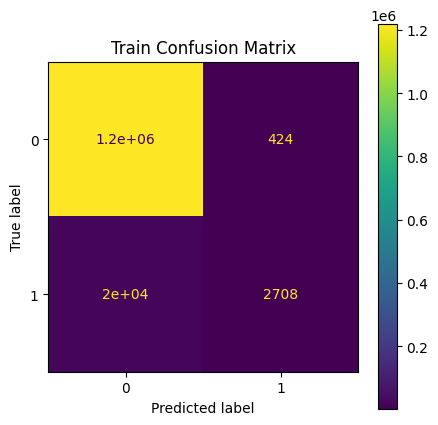

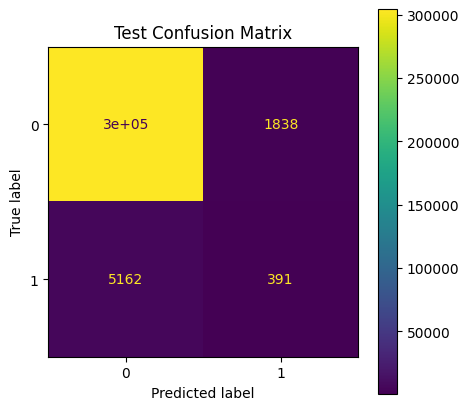

In [1]:
import pandas as pd
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    ConfusionMatrixDisplay
)
from xgboost import XGBClassifier
import matplotlib.pyplot as plt

# 1. Load data
train_df = pd.read_csv('/teamspace/studios/this_studio/physionet_train.csv')
test_df  = pd.read_csv('/teamspace/studios/this_studio/physionet_test.csv')

# 2. (Optional) pull out PatientID
train_ids = train_df['PatientID']
test_ids  = test_df['PatientID']

# 3. Split off features/target
X_train_full = train_df.drop(['SepsisLabel', 'PatientID'], axis=1)
y_train      = train_df['SepsisLabel']
X_test_full  = test_df.drop (['SepsisLabel', 'PatientID'], axis=1)
y_test       = test_df['SepsisLabel']

# 4. Define imputation groups
lin_features  = ['HR','O2Sat','Temp','SBP','MAP','DBP','Resp','EtCO2']
mice_features = [c for c in X_train_full.columns if c not in lin_features]

# 5. Linear interpolate
X_train_lin = X_train_full[lin_features].interpolate(method='linear', limit_direction='both')
X_test_lin  = X_test_full[lin_features].interpolate(method='linear', limit_direction='both')

# 6. MICE on the rest
mice_imp = IterativeImputer(random_state=42)
X_train_mice = pd.DataFrame(
    mice_imp.fit_transform(X_train_full[mice_features]),
    columns=mice_features, index=X_train_full.index
)
X_test_mice = pd.DataFrame(
    mice_imp.transform(X_test_full[mice_features]),
    columns=mice_features, index=X_test_full.index
)

# 7. Recombine
X_train = pd.concat([X_train_lin,  X_train_mice], axis=1)
X_test  = pd.concat([X_test_lin,   X_test_mice],  axis=1)

# 8. Train XGBoost
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
model.fit(X_train, y_train)

# 9a. Evaluate on TRAIN set
y_pred_train = model.predict(X_train)
acc_tr  = accuracy_score(y_train, y_pred_train)
prec_tr = precision_score(y_train, y_pred_train, zero_division=0)
rec_tr  = recall_score(y_train, y_pred_train, zero_division=0)
f1_tr   = f1_score(y_train, y_pred_train, zero_division=0)
tn_tr, fp_tr, fn_tr, tp_tr = confusion_matrix(y_train, y_pred_train).ravel()

print("=== TRAINING SET ===")
print(f"Accuracy        : {acc_tr:.4f}")
print(f"Precision       : {prec_tr:.4f}")
print(f"Recall          : {rec_tr:.4f}")
print(f"F1 Score        : {f1_tr:.4f}")
print(f"False Negatives : {fn_tr}\n")

# 9b. Evaluate on TEST set
y_pred_test = model.predict(X_test)
acc_te  = accuracy_score(y_test, y_pred_test)
prec_te = precision_score(y_test, y_pred_test, zero_division=0)
rec_te  = recall_score(y_test, y_pred_test, zero_division=0)
f1_te   = f1_score(y_test, y_pred_test, zero_division=0)
tn_te, fp_te, fn_te, tp_te = confusion_matrix(y_test, y_pred_test).ravel()

print("=== TEST SET ===")
print(f"Accuracy        : {acc_te:.4f}")
print(f"Precision       : {prec_te:.4f}")
print(f"Recall          : {rec_te:.4f}")
print(f"F1 Score        : {f1_te:.4f}")
print(f"False Negatives : {fn_te}\n")

# 10. (Optional) plot confusion matrices
for name, y_true, y_pred in [
    ("Train", y_train,   y_pred_train),
    ("Test",  y_test,    y_pred_test)
]:
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(cm, display_labels=model.classes_)
    fig, ax = plt.subplots(figsize=(5,5))
    disp.plot(ax=ax)
    plt.title(f"{name} Confusion Matrix")
    plt.show()